# qMC integration on a $d$-simplex

The `Sort` and `Root` transformations $\mathbf{x}\rightarrow\mathbf{u}$, $\mathbf{x}\in[0,1]^d, \mathbf{u}\in T_d$ studied here are defined in

    Tim Pillards, Ronald Cools
    "Transforming low-discrepancy sequences from a cube to a simplex"
    Journal of Computational and Applied Mathematics
    Volume 174, Issue 1, 2005, Pages 29-42
    
https://doi.org/10.1016/j.cam.2004.03.019

There are a few more transformations described in that paper, which do not fit our needs.

- `Drop` discards sequence points, retains only $N / d!$ out of $N$ points.
- `Mirror` is discontinuous.
- `Origami` becomes exponentially hard for large $d$.
- `Shift` is not defined for $d > 2$.

In [2]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [3]:
import Sobol: SobolSeq, next!, skip

"""
    Volume of a d-dimensional simplex.
"""
simplex_vol(d::Int) = 1 / factorial(d);

"""
    Quasi Monte Carlo integration on a d-dimensional simplex.

    `f`        Integrand.
    `d`        Dimension of the problem.
    `trans`    Transformation from a d-dimensional unit cube to the simplex.
    `jacobian` Jacobian of the transformation.
    `seq`      Sobol low-discrepancy-sequence.
    `N`        Number of samples.
"""
function qMCIntegrateInSimplex(f, d::Int, trans, jacobian, seq::SobolSeq, N::Int)
    s = 0
    for i = 1:N
        x = next!(seq)
        u = trans(x)
        if u[1] < 0 || u[end] > 1
            continue
        end
        s += f(u) * jacobian(u)
    end
    s / N
end;

## `Sort` transformation of a $d$-dimensional unit cube

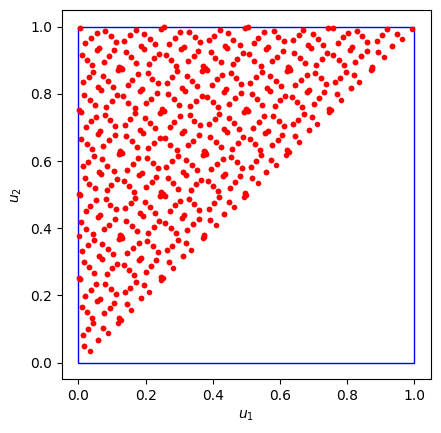

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/igor/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [4]:
seq = SobolSeq(2)

p = reduce(hcat, sort(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.plot(p[:,1], p[:,2], "r.")
plt.gca().add_patch(plt.matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="b", facecolor="none"))
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## `Root` transformation of a $d$-dimensional unit cube

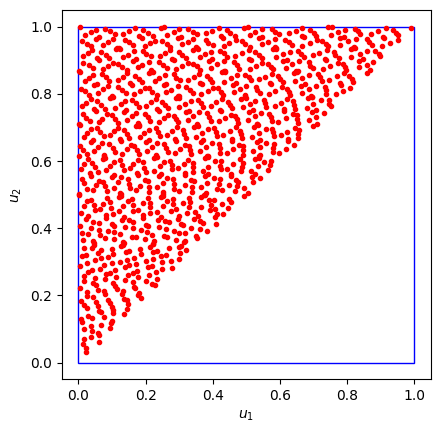

In [5]:
"""
    Make a Root transformation from a d-dimensional unit cube to the simplex.
"""
function make_trans_root(d::Int)
    x -> begin
        u = Vector{Float64}(undef, d)
        u[d] = x[d] ^ (1.0/d)
        for s = d-1:-1:1
            u[s] = u[s + 1] * (x[s] ^ (1.0 / s))
        end
        return u
    end
end;

seq = SobolSeq(2)
trans = make_trans_root(2)

p = reduce(hcat, trans(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.plot(p[:,1], p[:,2], "r.")
plt.gca().add_patch(plt.matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="b", facecolor="none"))
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## `ExpDiff` transformation of a $d$-dimensional unit cube

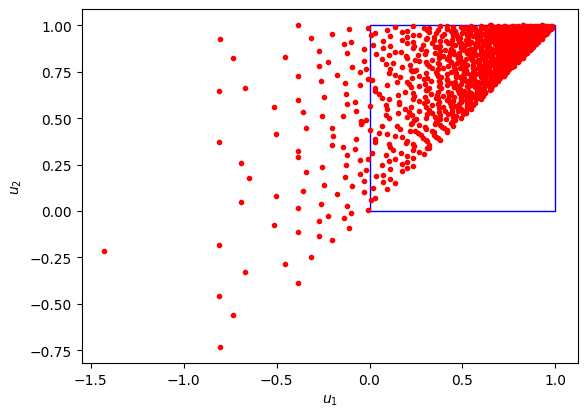

In [6]:
"""
    Make an ExpDiff transformation x -> u such that x ∈ [0,1]^d and -∞ < u_1 ≤ u_2 ≤ ... ≤ u_d ≤ 1.

    `τ` Parameter of the exponential decay function.
"""
function make_trans_expdiff(d::Int, τ::Real)
    x -> begin
        u = Vector{Float64}(undef, length(x))
        u[d] = 1 + τ*log(1 - x[d])
        for i = d-1:-1:1
            u[i] = u[i+1] + τ*log(1 - x[i])
        end
        u
    end
end

"""
    Make Jacobian of the ExpDiff transformation.
"""
function make_jacobian_expdiff(d::Int, τ::Real)
    u -> τ^d / exp(-(1 - u[1]) / τ)
end

seq = SobolSeq(2)
trans = make_trans_expdiff(2, 0.25)

p = reduce(hcat, trans(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.gca().add_patch(plt.matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="b", facecolor="none"))
plt.plot(p[:,1], p[:,2], "r.")
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## Scan a range of sample numbers $N$

In [20]:
function scan_N_range(f, d::Int, trans, jacobian, N_step::Int, N_chunks::Int; verbose = false)
    N_list = zeros(Int, N_chunks)
    chunks = zeros(Float64, N_chunks)
    
    seq = SobolSeq(d)
    seq = skip(seq, N_step * N_chunks) # Acclaimed better uniformity see Sobol.jl docs
    for i = 1:N_chunks
        N = i * N_step
        N_list[i] = N
        
        chunks[i] = qMCIntegrateInSimplex(f, d, trans, jacobian, seq, N)
        
        if verbose
            println("Chunk $i: N ∈ [$N; $(N + N_step)[: contribution = $(chunks[i])")
            flush(stdout)
        end
    end
    results = cumsum(chunks)
    for i = 1:N_chunks
        results[i] /= i
    end
    (N_list, results)
end

function plot_N_convergence(N_list, div_list, label_list, pdf_filename; title = nothing)
    fig, axes = plt.subplots(1, 2)
    if !isnothing(title)
        fig.suptitle(title)
    end
    
    fig.tight_layout()
    
    y_min, y_max = Inf, -Inf
    for (div, label) in Iterators.zip(div_list, label_list)
        y = abs.(div)
        axes[1].loglog(N_list, y, lw=0.5, label = label)
        y_min = min(y_min, minimum(y))
        y_max = max(y_max, maximum(y))
        for i = -3:5
            axes[1].loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
            axes[1].loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
        end
    end

    axes[1].set_xlabel(raw"$N$")
    axes[1].set_ylabel(raw"$|I - I_{ref}|$")
    axes[1].set_xlim(N_list[1], N_list[end])
    axes[1].set_ylim(y_min, y_max)
    axes[1].legend()
    
    y_min, y_max = Inf, -Inf
    for (div, label) in Iterators.zip(div_list, label_list)
        y = abs.(div) .* N_list
        axes[2].semilogx(N_list, y, lw=0.5, label = label)
        y_min = min(y_min, minimum(y))
        y_max = max(y_max, maximum(y))
    end
        
    axes[2].set_xlabel(raw"$N$")
    axes[2].set_ylabel(raw"$N|I - I_{ref}|$")
    axes[2].set_xlim(N_list[1], N_list[end])
    axes[2].set_ylim(y_min, y_max)
    axes[2].legend()
    
    plt.savefig(pdf_filename)
end

plot_N_convergence (generic function with 1 method)

## $d = 1$

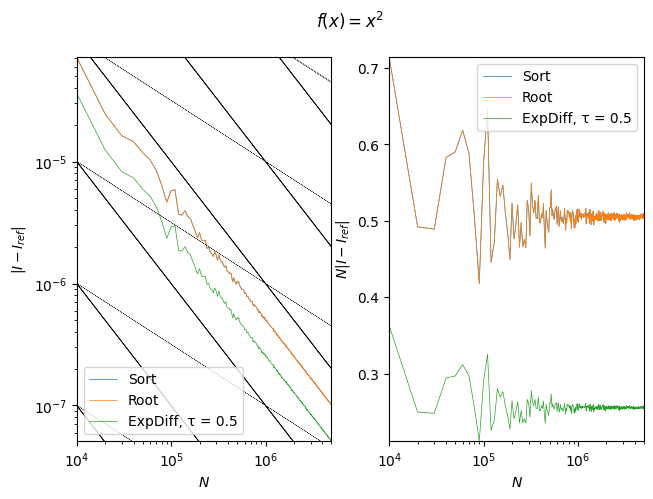

193.760288 seconds (3.76 G allocations: 223.967 GiB, 5.42% gc time, 0.02% compilation time)
187.503407 seconds (3.76 G allocations: 223.967 GiB, 5.45% gc time, 0.01% compilation time)
198.213823 seconds (3.59 G allocations: 213.863 GiB, 4.54% gc time, 0.01% compilation time)


In [25]:
d = 1
seq = SobolSeq(d)

τ = 0.5
N_step = 10000
N_chunks = 500

f = x -> sum(x.^2)
ref = 1/3

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_x2_1d.pdf",
                    title = raw"$f(x) = x^2$")

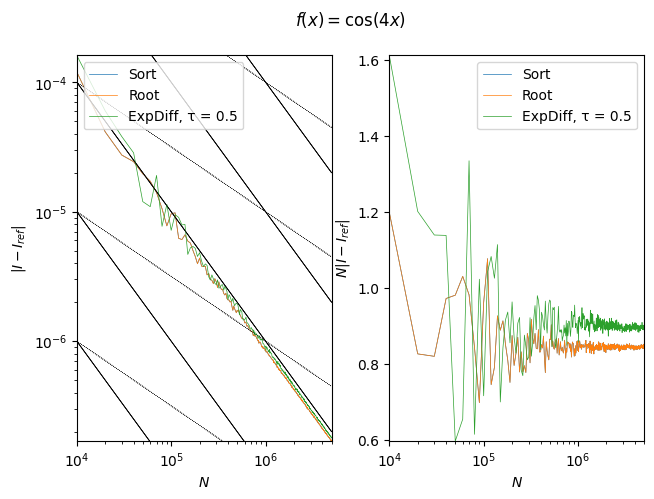

263.665847 seconds (5.01 G allocations: 298.622 GiB, 4.99% gc time, 0.02% compilation time)
261.935106 seconds (5.01 G allocations: 298.621 GiB, 4.77% gc time, 0.01% compilation time)
262.755775 seconds (4.67 G allocations: 278.414 GiB, 4.47% gc time, 0.01% compilation time)


In [27]:
d = 1
seq = SobolSeq(d)

τ = 0.5
N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 4

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_cos4x_1d.pdf",
                   title = raw"$f(x) = \cos(4x)$")

## $d = 2$

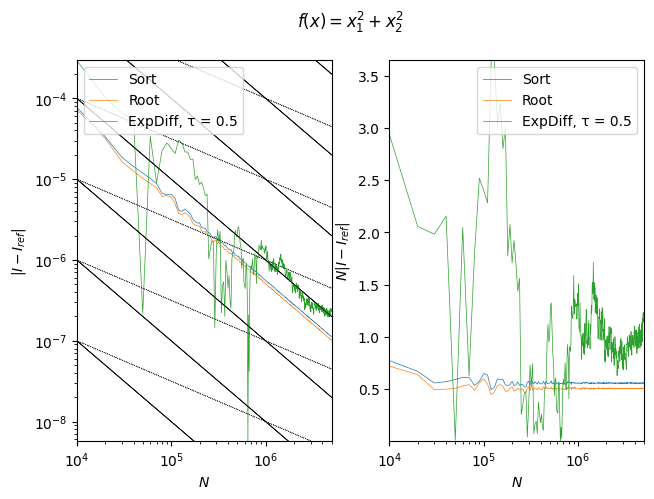

258.338447 seconds (3.76 G allocations: 279.958 GiB, 10.54% gc time, 0.02% compilation time)
243.648427 seconds (3.76 G allocations: 279.958 GiB, 10.81% gc time, 0.01% compilation time)
249.759601 seconds (3.25 G allocations: 242.070 GiB, 9.68% gc time, 0.01% compilation time)


In [30]:
d = 2
seq = SobolSeq(d)

τ = 0.5
N_step = 10000
N_chunks = 500

f = x -> sum(x.^2)
ref = 1/3

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_x2_2d.pdf",
                   title = raw"$f(x) = x_1^2 + x_2^2$")

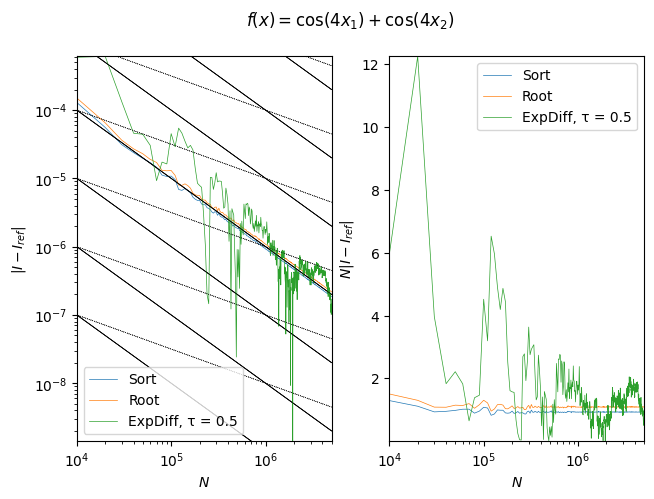

388.923030 seconds (5.01 G allocations: 373.277 GiB, 10.63% gc time, 0.01% compilation time)
399.361297 seconds (5.01 G allocations: 373.276 GiB, 10.67% gc time, 0.01% compilation time)
325.622547 seconds (3.99 G allocations: 297.500 GiB, 9.29% gc time, 0.01% compilation time)


In [32]:
d = 2
seq = SobolSeq(d)

τ = 0.5
N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 4

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_cos4x_2d.pdf",
                   title = raw"$f(x) = \cos(4x_1) + \cos(4x_2)$")

## $d = 3$

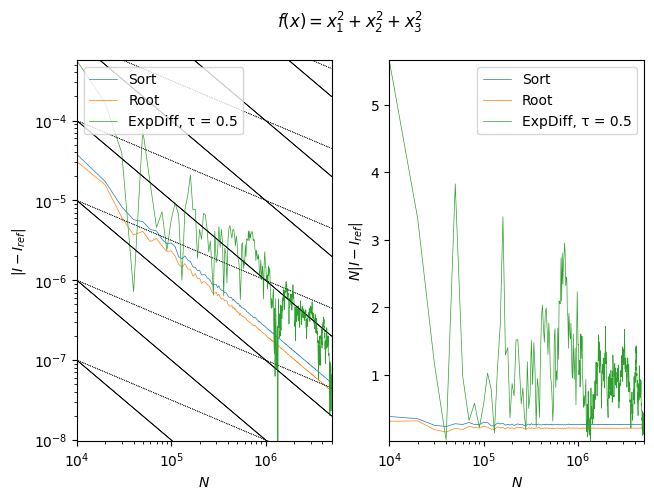

In [35]:
d = 3
seq = SobolSeq(d)

τ = 0.5
N_step = 10000
N_chunks = 500

f = x -> sum(x.^2)
ref = 1/6

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_x2_3d.pdf",
                   title = raw"$f(x) = x_1^2 + x_2^2 + x_3^2$")

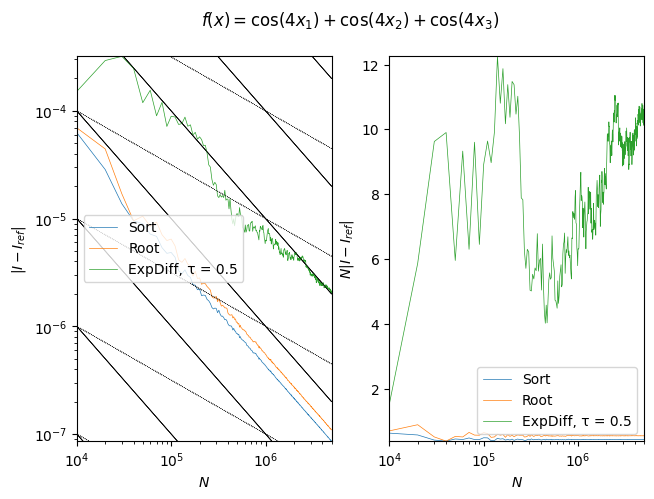

387.688299 seconds (5.01 G allocations: 373.277 GiB, 8.95% gc time, 0.01% compilation time)
499.638869 seconds (5.01 G allocations: 373.276 GiB, 7.59% gc time, 0.01% compilation time)
265.171677 seconds (3.31 G allocations: 246.983 GiB, 8.23% gc time, 0.01% compilation time)


In [39]:
d = 3
seq = SobolSeq(d)

τ = 0.5
N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 8

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_cos4x_3d.pdf",
                   title = raw"$f(x) = \cos(4x_1) + \cos(4x_2) + \cos(4x_3)$")

## `ExpDiff` transformation at various values of $\tau$

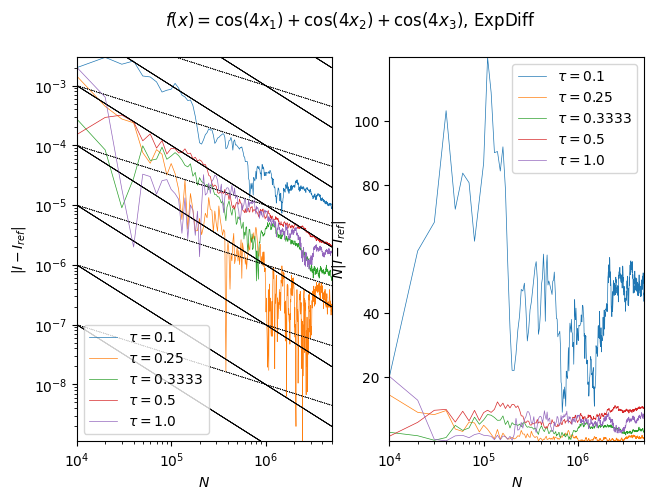

In [41]:
d = 3
seq = SobolSeq(d)

τ_list = [0.1, 0.25, 0.3333, 0.5, 1.0]
N_step = 10000
N_chunks = 500

f = x -> sum(cos.(4x))
ref = sin(4) / 8

results = []
for τ in τ_list
    N_list, r = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)
    push!(results, r)
end

plot_N_convergence(N_list,
                   [r .- ref for r in results],
                   [raw"$\tau = $" * string(τ) for τ in τ_list],
                   "qMC_cos4x_expdiff_tau.pdf",
                   title = raw"$f(x) = \cos(4x_1) + \cos(4x_2) + \cos(4x_3)$, ExpDiff")

## $d=3$, integrand with interpolation

No interpolation.

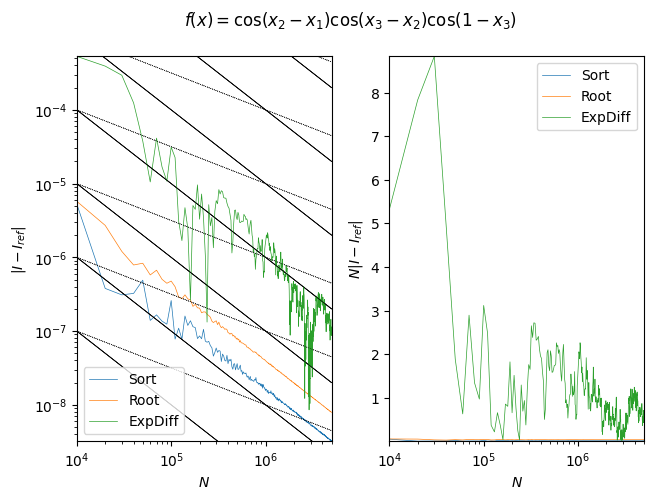

199.045737 seconds (2.51 G allocations: 186.640 GiB, 8.00% gc time, 0.01% compilation time)
289.655535 seconds (2.51 G allocations: 186.639 GiB, 5.46% gc time, 0.01% compilation time)
211.786131 seconds (2.51 G allocations: 186.639 GiB, 7.53% gc time, 0.01% compilation time)


In [43]:
d = 3
seq = SobolSeq(d)

τ = 0.25
N_step = 10000
N_chunks = 500

# No interpolation
f = x -> cos(x[2] - x[1]) * cos(x[3] - x[2]) * cos(1 - x[3])
ref = (2*sin(1) - cos(1)) / 8

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff"],
                   "qMC_interp_3d_exact.pdf",
                    title = raw"$f(x) = \cos(x_2-x_1) \cos(x_3-x_2) \cos(1-x_3)$")

Interpolation: 101 knots

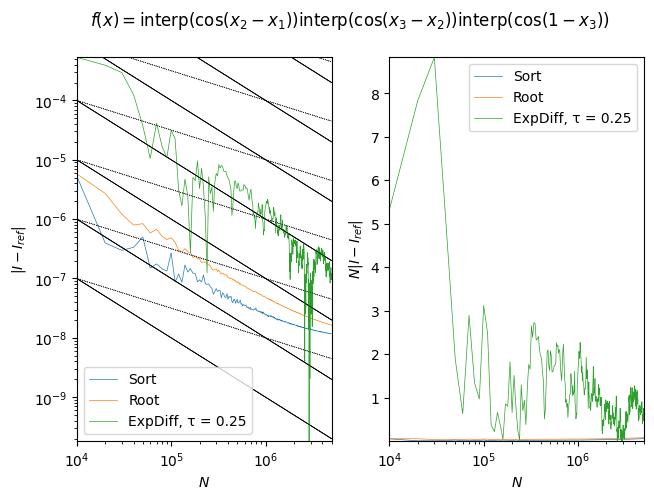

454.256657 seconds (15.03 G allocations: 373.277 GiB, 9.47% gc time, 0.01% compilation time)
545.713013 seconds (15.03 G allocations: 373.277 GiB, 7.74% gc time, 0.00% compilation time)
415.074006 seconds (12.05 G allocations: 328.838 GiB, 9.07% gc time, 0.00% compilation time)


In [54]:
import Interpolations: LinearInterpolation

d = 3
seq = SobolSeq(d)

τ = 0.25
N_step = 10000
N_chunks = 500

knots = range(0, stop=1.0, length=101)
cos_interp = LinearInterpolation(knots, cos.(knots))
f = x -> cos_interp(x[2] - x[1]) * cos_interp(x[3] - x[2]) * cos_interp(1 - x[3])
ref = 0.1428263957027626 # From Mathematica

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_interp_3d_101.pdf",
                   title = raw"$f(x) = \mathrm{interp}(\cos(x_2-x_1)) \mathrm{interp}(\cos(x_3-x_2)) \mathrm{interp}(\cos(1-x_3))$")

Interpolation: 11 knots

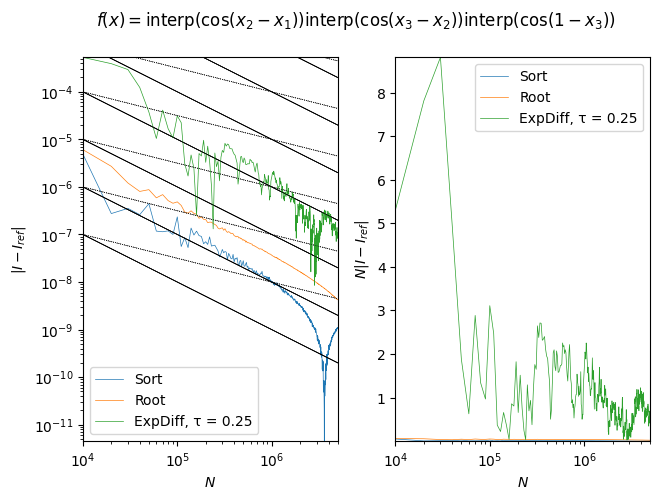

451.719549 seconds (15.03 G allocations: 373.277 GiB, 10.16% gc time, 0.01% compilation time)
521.732801 seconds (15.03 G allocations: 373.277 GiB, 8.21% gc time, 0.00% compilation time)
380.594349 seconds (12.05 G allocations: 328.838 GiB, 8.95% gc time, 0.01% compilation time)


In [55]:
d = 3
seq = SobolSeq(d)

τ = 0.25
N_step = 10000
N_chunks = 500

knots = range(0, stop=1.0, length=11)
cos_interp = LinearInterpolation(knots, cos.(knots))
f = x -> cos_interp(x[2] - x[1]) * cos_interp(x[3] - x[2]) * cos_interp(1 - x[3])
ref = 0.14247358381062378 # From Mathematica

@time N_list, results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_step, N_chunks)
@time N_list, results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_step, N_chunks)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_interp_3d_11.pdf",
                   title = raw"$f(x) = \mathrm{interp}(\cos(x_2-x_1)) \mathrm{interp}(\cos(x_3-x_2)) \mathrm{interp}(\cos(1-x_3))$")